In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Conv2D, Dropout, MaxPooling2D, AveragePooling2D, BatchNormalization, Dense, Activation, PReLU ,Flatten, GlobalAveragePooling2D, Lambda, LeakyReLU, PReLU
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold

Using TensorFlow backend.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
"""config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
K.set_session(tf.Session(config=config))"""

'config = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.33\nK.set_session(tf.Session(config=config))'

In [5]:
from random import shuffle
train_data = pd.read_csv('CROSS VAL DATASET/MIXED DATA.csv')
#train_data_2 = train_data.sample(frac=1).reset_index(drop=True)
Y = train_data[['Label']]
print(len(Y))
print(Y)
kf = KFold(n_splits = 5)

skf = StratifiedKFold( 5, random_state = 7, shuffle = True)
"""
train_data_2.to_csv(r'CROSS VAL DATASET\MIXED DATA.csv')

skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True) """

17553
          Label
0         COVID
1      NONCOVID
2         COVID
3      NONCOVID
4      NONCOVID
...         ...
17548  NONCOVID
17549     COVID
17550     COVID
17551  NONCOVID
17552  NONCOVID

[17553 rows x 1 columns]


"\ntrain_data_2.to_csv(r'CROSS VAL DATASET\\MIXED DATA.csv')\n\nskf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True) "

In [6]:
from tensorflow.keras import backend as K

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred): 
    p, r = precision(y_true, y_pred), recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

metrics = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           precision,
           recall,
           f1_score,
           tf.keras.metrics.AUC(name='auc')]

In [7]:
def Res_Block(x_shortcut, filters, size = 3, stride = 1 ):
    x = Conv2D(filters = filters, kernel_size = size, strides = stride, padding="same") (x_shortcut)
    x = BatchNormalization()(x)
    x = PReLU(shared_axes=[1,2]) (x)
    
    x = Add ()([x_shortcut,x ])
    x = PReLU(shared_axes=[1,2]) (x)
    return(x)

In [37]:
def DarkCovidNetNRC():
    
    in_img = Input(shape= (256,256,3))
    
    C1 = Conv2D(filters = 16, kernel_size = 3, strides = 2, padding="same") (in_img)
    C1 = BatchNormalization() (C1)
    C1 = PReLU(shared_axes=[1,2]) (C1)
    
    
    C2 = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding="same") (C1)
    C2 = BatchNormalization() (C2)
    C2 = PReLU(shared_axes=[1,2]) (C2)
    
    
    C3 = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding="same") (C2)
    C3 = BatchNormalization() (C3)
    C3 = PReLU(shared_axes=[1,2]) (C3)
    C3 = Dropout(0.15) (C3) 
    
    C4 = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding="same") (C3)
    C4 = BatchNormalization() (C4)
    C4 = PReLU(shared_axes=[1,2]) (C4)
    R1 = Res_Block(C4, filters = 32, size = 3, stride = 1)
    
    C5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding="same") (R1)
    C5 = BatchNormalization() (C5)
    C5 = PReLU(shared_axes=[1,2]) (C5)
    C5 = Dropout(0.15) (C5) 
    R2 = Res_Block(C5, filters = 64, size = 3, stride = 1)
    R2 = Dropout(0.15) (R2)   
    
    A1 = Add ()([C3,R2 ])
    A1 = PReLU(shared_axes=[1,2]) (A1)
    
    
    C6 = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding="same") (A1)
    C6 = BatchNormalization() (C6)
    C6 = PReLU(shared_axes=[1,2]) (C6)
    C6 = Dropout(0.2) (C6)

    C7 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding="same") (C6)
    C7 = BatchNormalization() (C7)
    C7 = PReLU(shared_axes=[1,2]) (C7)
    C7 = Dropout(0.15) (C7)
    R3 = Res_Block(C7, filters = 64, size = 3, stride = 1) 
    R3 = Dropout(0.15) (R3)

    
    C8 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding="same") (R3)
    C8 = BatchNormalization() (C8)
    C8 = PReLU(shared_axes=[1,2]) (C8)
    C8 = Dropout(0.2) (C8)
    R4 = Res_Block(C8, filters = 128, size = 3, stride = 1)
    R4 = Dropout(0.2) (R4)
    
    A2 = Add ()([C6,R4 ])
    A2 = PReLU(shared_axes=[1,2]) (A2)

    
    C9 = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding="same") (A2)
    C9 = BatchNormalization() (C9)
    C9 = PReLU(shared_axes=[1,2]) (C9)
    C9 = Dropout(0.25) (C9)
    
    C10 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding="same") (C9)
    C10 = BatchNormalization() (C10)
    C10 = PReLU(shared_axes=[1,2]) (C10)
    C10 = Dropout(0.2) (C10)
    R5 = Res_Block(C10, filters = 128, size = 3, stride = 1)
    R5 = Dropout(0.2) (R5)
    
    C11 = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding="same") (R5)
    C11 = BatchNormalization() (C11)
    C11 = PReLU(shared_axes=[1,2]) (C11)
    C11 = Dropout(0.25) (C11)
    R6 = Res_Block(C11, filters = 256, size = 3, stride = 1)
    R6 = Dropout(0.25) (R6)
    
    A3 = Add ()([C9,R6])
    A3 = PReLU(shared_axes=[1,2]) (A3)
    
    
    C12 = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding="same") (A3)
    C12 = BatchNormalization() (C12)
    C12 = PReLU(shared_axes=[1,2]) (C12)
    C12 = Dropout(0.25) (C12)
    
    C13 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding="same") (C12)
    C13 = BatchNormalization() (C13)
    C13 = PReLU(shared_axes=[1,2]) (C13)
    C13 = Dropout(0.2) (C13)
    R7 = Res_Block(C13, filters = 128, size = 3, stride = 1)
    R7 = Dropout(0.2) (R7)
    
    C14 = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding="same") (R7)
    C14 = BatchNormalization() (C14)
    C14 = PReLU(shared_axes=[1,2]) (C14)
    C14 = Dropout(0.25) (C14)
    R8 = Res_Block(C14, filters = 256, size = 3, stride = 1)
    R8 = Dropout(0.25) (R8)
    
    A4 = Add ()([C12,R8])
    A4 = PReLU(shared_axes=[1,2]) (A4)
    
    model = Conv2D(filters = 2, kernel_size = 1, strides = 1, padding="same") (A4)
    model = BatchNormalization() (model)
    model = PReLU(shared_axes=[1,2]) (model)
    
    model = Flatten()(model)
    output = Dense(2,activation="softmax")(model)
    model = Model(inputs = in_img, outputs = output)
    return model

In [9]:
model = DarkCovidNetNRC()
"""model.compile(loss = "categorical_crossentropy", optimizer = 'adam' , metrics=["accuracy",
                                                                                  f1_m, #F1 score
                                                                                  precision_m, #Precision (TP/ TOTAL)
                                                                                  recall_m]) #Recall/Sensitivity (TP / (TP+FN))"""
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 128, 128, 16) 16          batch_normalization[0][0]        
______________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.235999 to fit



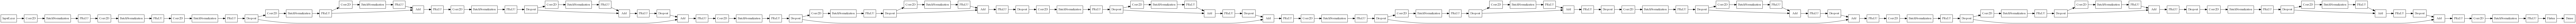

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=False,
    expand_nested=False,
    rankdir="LR",
    dpi=800)

In [11]:
data_path = "CROSS VAL DATASET/MIXED DATASET"
#test_data_path = "Dataset without CT/test"
"""img_rows = 255
img_cols = 249

epochs = 150
batch_size = 32
"""

img_rows = 256
img_cols = 256
idg = ImageDataGenerator(rescale= 1. / 255)



In [12]:
def get_model_name(k):
    return str(k)+'.h5'

In [13]:
import gc
gc.collect()

34593

In [14]:
"""TB = tf.keras.callbacks.TensorBoard(log_dir='Training_Logs\CROSS_VALIDATION\K_Fold_{}')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "ResDarkCovNet/CROSS_VAL_Training/K_Fold_{}.h5", monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto')


#model.load_weights("ResDarkCovNet/DarkCovidNet.h5")"""

'TB = tf.keras.callbacks.TensorBoard(log_dir=\'Training_Logs\\CROSS_VALIDATION\\K_Fold_{}\')\ncheckpoint = tf.keras.callbacks.ModelCheckpoint(\n    "ResDarkCovNet/CROSS_VAL_Training/K_Fold_{}.h5", monitor=\'val_loss\', verbose=1, save_best_only=True,\n    save_weights_only=True, mode=\'auto\')\n\n\n#model.load_weights("ResDarkCovNet/DarkCovidNet.h5")'

In [15]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto')

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience = 30,
    verbose= 1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


In [17]:
hist_path = "Our Solution History\MIXED_CROSS_VALIDATION\ "
model_path = "Our Solution History/MIXED_CROSS_VAL_TRAINING/our_model_mixed_"

In [18]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
RES = []

In [19]:
import matplotlib.pyplot as plt
import cv2

In [41]:

fold_var = 1
num_epochs = 100
batch_size = 32
for train_index, val_index in kf.split(np.zeros(len(Y)),Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]

    train_data_generator = idg.flow_from_dataframe(training_data, directory = data_path,
                                batch_size = batch_size,                  
                                target_size=(img_rows, img_cols),
                                x_col = "Filename", y_col = "Label",
                                class_mode = "categorical", shuffle = True)
    valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = data_path,
                            batch_size = batch_size, 
                            target_size=(img_rows, img_cols),
                            x_col = "Filename", y_col = "Label",
                            class_mode = "categorical", shuffle = False)
    
    model = our_solution_v2()
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam' , metrics=[metrics])
                                                                            #F1 score
                                                                               #Precision (TP/ TOTAL)
                                                                            #Recall/Sensitivity (TP / (TP+FN))
    if (os.path.isfile(model_path+str(fold_var)+".h5")):
        K.set_value(model.optimizer.learning_rate, 1e-5)
        print("model ", fold_var, "found")

        model.load_weights(model_path+str(fold_var)+".h5")
        """
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_path+get_model_name(fold_var) , monitor='val_accuracy', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto')
        
        TB = tf.keras.callbacks.TensorBoard(log_dir=hist_path + get_model_name(fold_var))
        
        print("training")
        
        
        history = model.fit(train_data_generator,
        epochs=num_epochs, 
        callbacks=[checkpoint, reduce_lr_on_plateau, early_stopping],
        validation_data=valid_data_generator)
        """
        """for batch in valid_data_generator:
            imgs = batch[0]
            classes = batch[1]
            for i in range(len(imgs)):
                
                p = model.predict(imgs[i].reshape(1,img_rows,img_cols,3))[0]
                if np.around(p[0]) == 1:
                    y_ = "COVID"
                else:
                    y_ = "No-COVID"
                    
                if classes[i][0] == 1:
                    y = "COVID"
                else:
                    y = "No-COVID"
                    
                print("network's prediction: ", p, " ", y_)
                print("real class: ", classes[i], " ", y)
                plt.imshow(imgs[i])
                plt.show()
            break
        """    
        model.evaluate(valid_data_generator, verbose = 1)
                
        results = dict(zip(model.metrics_names,results))
        RES.append(results)
        
        tf.keras.backend.clear_session()
        
        
    else:
        K.set_value(model.optimizer.learning_rate, 1e-3)

        checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_path+get_model_name(fold_var) , monitor='val_accuracy', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto')
        TB = tf.keras.callbacks.TensorBoard(log_dir=hist_path + get_model_name(fold_var))

        history = model.fit(train_data_generator,
        epochs=num_epochs,
        callbacks=[TB,checkpoint, reduce_lr_on_plateau, early_stopping],
        validation_data=valid_data_generator)

        model.load_weights(model_path+str(fold_var)+".h5")

        results = model.evaluate(valid_data_generator)


        results = dict(zip(model.metrics_names,results))
        RES.append(results)

        tf.keras.backend.clear_session()
        
        
    fold_var += 1

Found 14041 validated image filenames belonging to 2 classes.
Found 3511 validated image filenames belonging to 2 classes.
model  1 found
110/110 [==============================] - 34s 275ms/step - loss: 0.1846 - accuracy: 0.9601 - precision: 0.9415 - recall: 0.9528 - f1_score: 0.9455 - auc: 0.9877
Found 14042 validated image filenames belonging to 2 classes.
Found 3510 validated image filenames belonging to 2 classes.
model  2 found
110/110 [==============================] - 33s 268ms/step - loss: 0.1244 - accuracy: 0.9603 - precision: 0.9691 - recall: 0.9694 - f1_score: 0.9680 - auc: 0.9877
Found 14041 validated image filenames belonging to 2 classes.
Found 3511 validated image filenames belonging to 2 classes.
model  3 found
110/110 [==============================] - 34s 284ms/step - loss: 0.1594 - accuracy: 0.9604 - precision: 0.9592 - recall: 0.9603 - f1_score: 0.9589 - auc: 0.9876
Found 14042 validated image filenames belonging to 2 classes.
Found 3510 validated image filenames b

In [22]:
for i in range(len(RES)):
    print(RES[i])


In [23]:
print("VALIDATION_ACCURACY")
print(VALIDATION_ACCURACY)
print("VALIDAITON_LOSS")
print(VALIDAITON_LOSS)

VALIDATION_ACCURACY
[]
VALIDAITON_LOSS
[]


In [42]:
batch_size = 16
Test_Path="TEST DATASET"
test_generator = idg.flow_from_directory(Test_Path,
                                batch_size = batch_size,                  
                                #target_size=(img_rows, img_cols),
                                class_mode = "categorical", shuffle = True)

print(test_generator.class_indices)

Found 540 images belonging to 2 classes.
{'COVID19': 0, 'OTHER': 1}


In [44]:

for i in range(5):
    model = our_solution_v2()
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam' , metrics=[metrics])
    model.load_weights(model_path+str(i+1)+".h5")
    results = model.evaluate(test_generator)
    

17/17 [==============================] - 10s 406ms/step - loss: 0.5135 - accuracy: 0.9542 - precision: 0.9399 - recall: 0.7297 - f1_score: 0.8124 - auc: 0.9841


In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
    model = DarkCovidDnet()
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam' , metrics=[metrics])
    model.load_weights(model_path+str(i+1)+".h5")
    for batch in test_generator:
            imgs = batch[0]
            classes = batch[1]
            for i in range(len(imgs)):
                
                p = model.predict(imgs[i].reshape(1,256,256,3))[0]
                if np.around(p[0]) == 1:
                    y_ = "COVID"
                else:
                    y_ = "No-COVID"
                    
                if classes[i][0] == 1:
                    y = "COVID"
                else:
                    y = "No-COVID"
                    
                print("network's prediction: ", p, " ", y_)
                print("real class: ", classes[i], " ", y)
                plt.imshow(imgs[i])
                plt.show()
            break